In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import collections
import math
from functools import partial

from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, RobustScaler

import tensorflow as tf
from tensorflow.python.data import Dataset

In [3]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

### Load data

In [4]:
df = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")
df_test = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_test.csv", sep=",")

In [5]:
# randomize data just to be sure not to get any pathological ordering effects
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))

In [6]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocessing pipeline

Normalizing inputs helps gradient descent not get stuck taking steps that are too big/small

In [7]:
# custom class that clips columns at a percentile
class PercentileClip(BaseEstimator, TransformerMixin):
    
    def __init__(self, percentiles):
        self.percentiles = percentiles
        self.cutoffs = None
    
    def fit(self, X, y):
        if isinstance(self.percentiles, collections.Iterable):
            self.cutoffs = [np.quantile(x, p) for p in self.percentiles]
        else:
            self.cutoffs = np.apply_along_axis(lambda x: np.quantile(x, self.percentiles), 0, X)
        return self
    
    def transform(self, X):
        return pd.DataFrame(X).clip(upper=self.cutoffs, axis=1).values

In [8]:
preprocessing = FeatureUnion(transformer_list=[
    ('norm1', Pipeline(steps=[
        ('col', FunctionTransformer(lambda x: x[['latitude', 'longitude', 'housing_median_age']], validate=False)),
        ('mms', MinMaxScaler(feature_range=(-1, 1)))
    ])),
    ('norm2', Pipeline(steps=[
        ('col', FunctionTransformer(lambda x: np.vectorize(math.log1p)(x[['households', 'median_income', 'total_bedrooms']]), validate=False)),
        ('mms', MinMaxScaler(feature_range=(-1, 1)))
    ])),
    ('norm3', Pipeline(steps=[
        ('col', FunctionTransformer(lambda x: x[['population', 'total_rooms']].values, validate=False)),
        ('max', PercentileClip(0.99)),
        ('mms', MinMaxScaler(feature_range=(-1, 1)))
    ])),
    ('norm4', FunctionTransformer(lambda x: (x['total_rooms'] / x['population']).clip(0, 5).values.reshape(-1, 1), validate=False))
])

y = df["median_house_value"] / 1000.0
y_test = df_test["median_house_value"] / 1000.0

X = preprocessing.fit_transform(df, y)
X_test = preprocessing.transform(df_test)

In [9]:
# set up feature columns for TF
col = [str(i) for i in range(X.shape[1])]
X = pd.DataFrame(X, columns=col)
X_test = pd.DataFrame(X_test, columns=col)
feature_columns = set([tf.feature_column.numeric_column(str(i)) for i in col])

In [10]:
# split into train and validate sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

### Define input functions

This controls how data is batched and shuffled during model training

In [11]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key: np.array(value) for key, value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
predict_input_fn = partial(input_fn, num_epochs=1, shuffle=False)
predict_train_input_fn = partial(predict_input_fn, X_train, y_train)
predict_valid_input_fn = partial(predict_input_fn, X_valid, y_valid)
predict_test_input_fn = partial(predict_input_fn, X_test, y_test)

### Function for training model

In [13]:
def predict_model(estimator, input_fn):
    predictions = estimator.predict(input_fn=input_fn)
    return np.array([item['predictions'][0] for item in predictions])

In [14]:
def train_model(learning_rate, steps, batch_size, hidden_units):
    """Trains a linear regression model of one feature.

    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    target_label: A `string` specifying the column that we are trying to predict
    """

    periods = 10
    steps_per_period = steps / periods
    
    # create input function for training
    train_input_fn = lambda: input_fn(X_train, y_train, batch_size=batch_size)
    
    # create a linear regressor object
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=feature_columns,
        hidden_units=hidden_units,
        optimizer=optimizer
    )

    # train the model and periodically assess loss metrics
    print("Training model...")
    print("RMSE (train, valid):")
    rmse_period = []
    for period in range (0, periods):
        # train the model, starting from the prior state
        dnn_regressor.train(
            input_fn=train_input_fn,
            steps=steps_per_period
        )

        # predictions
        pred_train = predict_model(dnn_regressor, predict_train_input_fn)
        pred_valid = predict_model(dnn_regressor, predict_valid_input_fn)
        
        # calculate error
        rmse_train = math.sqrt(mean_squared_error(pred_train, y_train))
        rmse_valid = math.sqrt(mean_squared_error(pred_valid, y_valid))
        rmse_period.append([rmse_train, rmse_valid])
        print("  period %02d: %0.2f, %0.2f" % (period, rmse_train, rmse_valid))

    print("Model training finished.")

    # graph of loss metrics over periods
    rmse_period = np.array(rmse_period)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(rmse_period[:, 0], label='train')
    plt.plot(rmse_period[:, 1], label='valid')
    plt.legend()
    plt.show()
    
    # output a table with calibration data
    calibration_data = pd.DataFrame({'pred': pred_train, 'y': y_train})
    display.display(calibration_data.describe())
    
    print("Final RMSE (train, valid): %0.2f, %0.2f" % (rmse_period[-1][0], rmse_period[-1][1]))
    
    return dnn_regressor

### Train model

Training model...
RMSE (train, valid):
  period 00: 231.44, 229.68
  period 01: 219.84, 218.07
  period 02: 200.15, 198.37
  period 03: 171.17, 169.43
  period 04: 134.97, 133.55
  period 05: 106.61, 106.51
  period 06: 102.91, 103.41
  period 07: 100.70, 101.09
  period 08: 98.65, 98.88
  period 09: 96.43, 96.67
Model training finished.


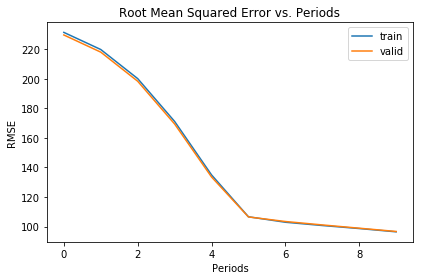

,pred,y
count,13600.0,13600.0
mean,208.3,207.5
std,56.2,116.3
min,17.6,15.0
25%,169.5,119.8
50%,204.9,180.5
75%,241.8,265.0
max,478.1,500.0


Final RMSE (train, valid): 96.43, 96.67


In [15]:
dnn_regressor = train_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10]
)

### Evaluate on test set

In [16]:
pred_test = predict_model(dnn_regressor, predict_test_input_fn)
rmse = math.sqrt(mean_squared_error(pred_test, y_test))
print("Final RMSE (test): %0.2f" % rmse)

Final RMSE (test): 95.54
